### Setup

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from model.lorenz96 import Lorenz96
from model.parameter import Parameter
from filtering.enkf import EnKF
from utils import default_generator
from utils.plotter import Plotter

### Parameters

In [2]:
generator = default_generator
forcing = Parameter(init_value=8, uncertainty=0.2, name="$F$", estimate=False)
n_states = 20

time_step = 0.05
init_time = 0
end_time = 200
ensemble_size = 40

x0_unperturbed = generator.normal(size=n_states)
x0 = x0_unperturbed.copy()
x0[0] += 0.01

initial_state_covariance = np.eye(n_states)
system_cov = lambda _: np.eye(n_states)
obs_cov = lambda _: 0.09 * np.eye(n_states)

H = lambda _: np.eye(n_states)

### Generate true state

In [3]:
l96 = Lorenz96(
    x0, time_step, n_states, forcing, system_cov, obs_cov, generator, solver="rk4"
)
times, states = l96.integrate(init_time, end_time)
l96.reset_model()
# l96.initial_condition[0] -= 2

### Generate observations (with noise)

In [4]:
assimilation_times = np.arange(1, end_time, 0.5)
observed = np.zeros((n_states, len(assimilation_times)))
observed_true = np.zeros((n_states, len(assimilation_times)))
for i, t in enumerate(assimilation_times):
    k = int(t / time_step)
    observed[:, i] = l96.observe(states[:, k], add_noise=True)
    observed_true[:, i] = l96.observe(states[:, k])

### EnKF twin experiment

100%|██████████| 398/398 [00:18<00:00, 21.30it/s]


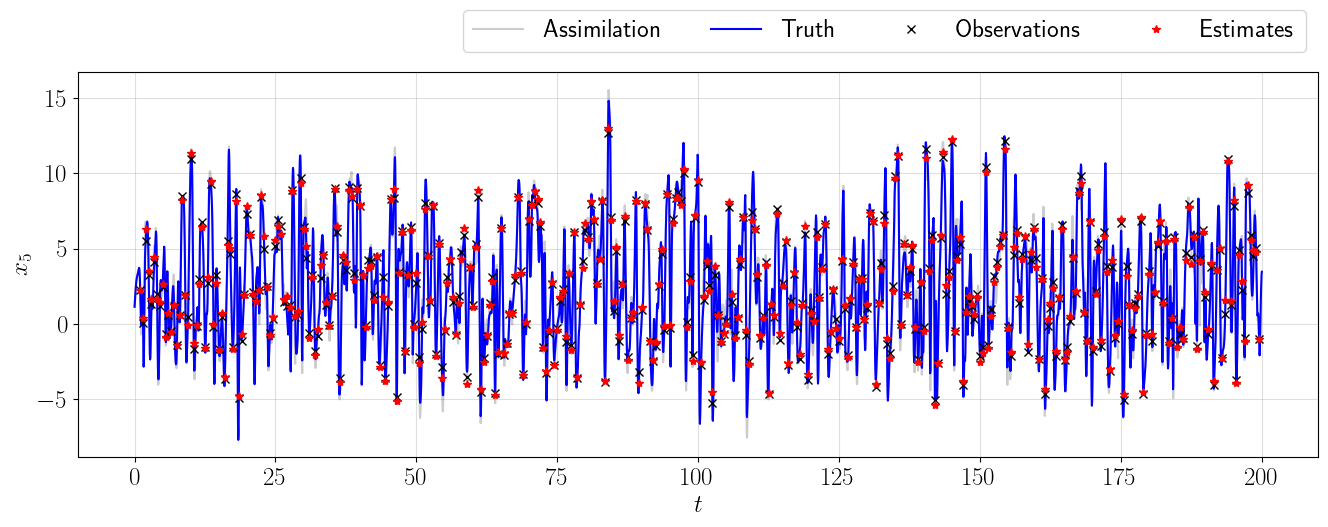

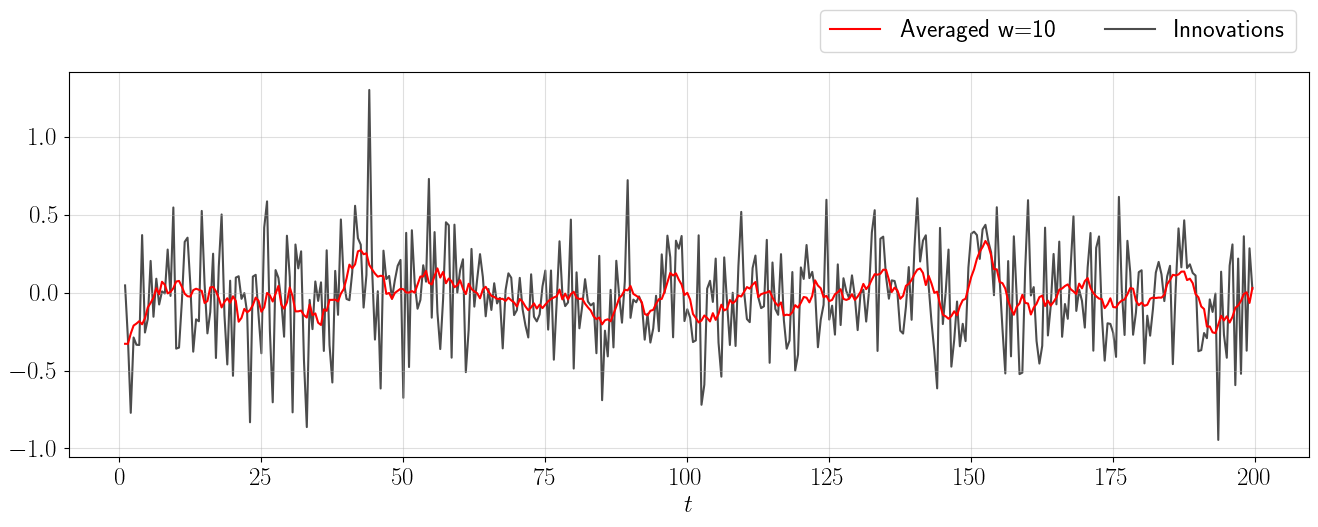

In [5]:
cut_off_time = None
f = EnKF(l96, x0, initial_state_covariance, ensemble_size, H)
results = f.filter(assimilation_times, observed, cut_off_time=cut_off_time)

# Add true states to compare
results.true_times = times
results.true_states = states

# Plot results
state_idx = 5
results.plot_filtering(state_idx, path=f"filter_{state_idx}.pdf")
results.plot_innovations(state_idx, window=10)
plt.show()

### Add a bias function to the model

In [6]:
idxs = np.arange(n_states)
a_coeff = 0.2 * forcing
l96.model_bias = lambda t, x: a_coeff * np.sin(2 * np.pi * idxs / n_states)

### EnKF for biased model

100%|██████████| 398/398 [00:23<00:00, 17.14it/s]


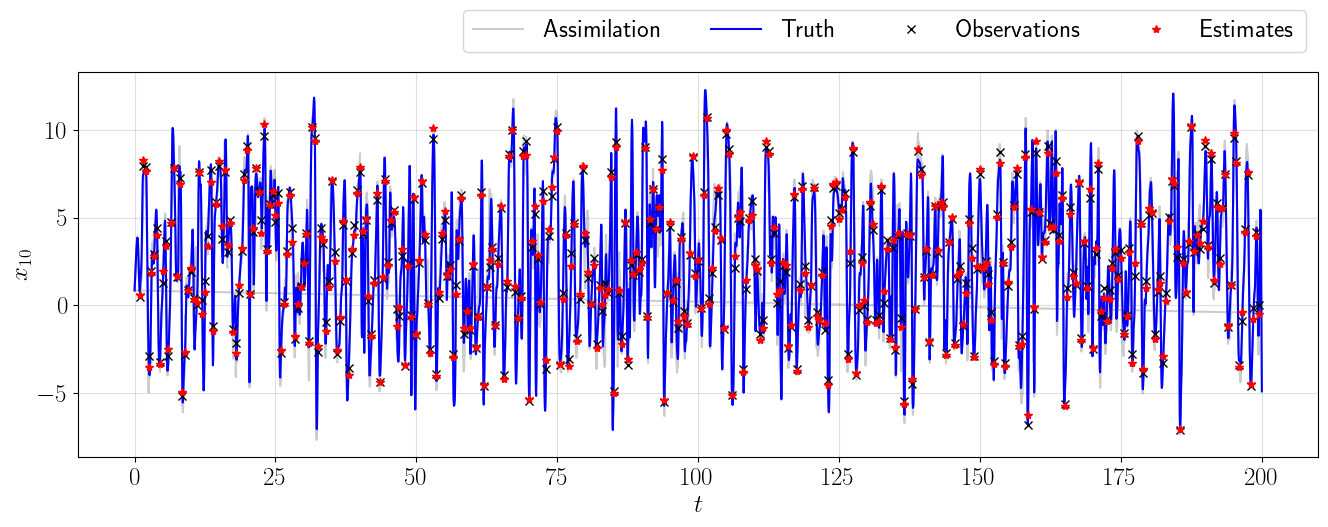

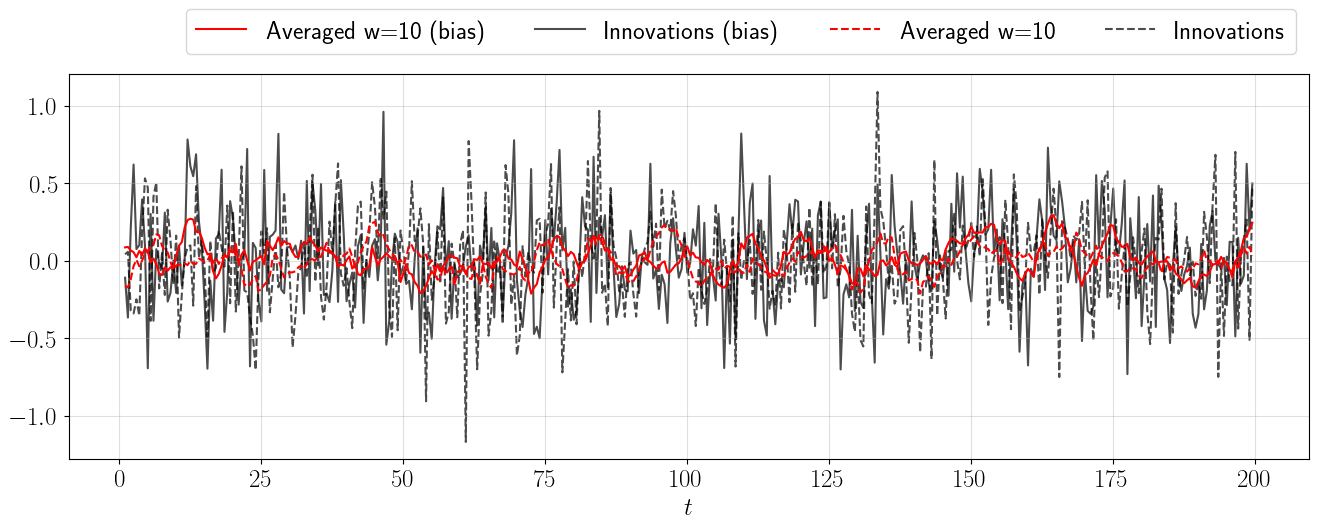

In [7]:
cut_off_time = None
f = EnKF(l96, x0, initial_state_covariance, ensemble_size, H)
results_biased = f.filter(
    assimilation_times, observed, cut_off_time=cut_off_time, run_id="bias"
)
results_biased.true_times = times
results_biased.true_states = states

sample = [0, 5, 10]
# sample = idxs
window = 10
for state_idx in sample:
    results.plot_filtering(state_idx, path=f"filter_{state_idx}.pdf")
    results_biased.plot_filtering(state_idx, path=f"filter_biased_{state_idx}.pdf")

    ax = results_biased.plot_innovations(state_idx, window=window)
    results.plot_innovations(
        state_idx,
        path=f"innovations_{state_idx}.pdf",
        ax=ax,
        window=window,
        linestyle="dashed",
    )
plt.show()